In [ ]:
%load_ext autoreload
%autoreload 2
import random
import numpy as np
import torch
import matplotlib.pyplot as plt


In [ ]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

from mixture_lower import Mixture
from guided_models import Diffusion
from chernoff_gpt import ChernoffGuidance

results = {}

# Diffusion parameters
n = T = 20
t_vals = np.arange(1, n+1)
c, delta = 4, 0.02
inner = delta * (1 + c * np.log(n) / n)**t_vals
alpha_t = 1 - (c * np.log(n) / n) * np.minimum(inner, 1)
alpha_t[0] = 1 - delta
d = 2

# Mixture setup
mu_0 = np.array([[5, 0], [-5, 0]])
var_0 = np.eye(d)
pi_0 = np.array([0.95, 0.05])
pi_0 /= np.sum(pi_0)
dist0 = Mixture(mu_0, var_0, pi_0)
diffusion_unguided = Diffusion(dist0, alpha_t, S=50_000)
# X_unguided = diffusion_unguided.calc_samples()
unguided_num_steps = T*50_000

X = diffusion_unguided.calc_samples()



In [ ]:
plt.scatter(X[:, -1, 0], X[:, -1, 1], alpha=0.1)

In [ ]:
B = 3
def reward_func_hard(x):
    """
    Hard step function for 2D input.
    Returns B when x[..., 0] < -7, and 0 otherwise.
    """
    x0 = np.asarray(x)[..., 0]
    return np.where(x0 < -7, B, 0)

expr = np.exp(reward_func_hard(X[:, -1, :]))
plt.plot(expr)

In [ ]:
from value_estimator import ValueEstimate
val_ensemble = ValueEstimate(X, expr, [128, 500, 500])
val_ensemble.train()


In [ ]:
from matplotlib import animation

# Create a grid of x values
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
xx1, xx2 = np.meshgrid(x1, x2)
grid_x = np.stack([xx1.ravel(), xx2.ravel()], axis=1)

fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(np.zeros_like(xx1), extent=[-10, 10, -10, 10], origin='lower', vmin=-B, vmax=B)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('v(x, t) over time')
cb = fig.colorbar(cax)

t_vals = list(range(1, n + 1))

def animate(t_idx):
    t = t_vals[t_idx]
    t_arr = np.full((grid_x.shape[0],), t)
    v = val_ensemble.predict_under_log(grid_x, t_arr)
    v = np.squeeze(v)
    v_img = v.reshape(xx1.shape)
    cax.set_data(v_img)
    ax.set_title(f'v(x, t={t})')
    return [cax]

ani = animation.FuncAnimation(fig, animate, frames=len(t_vals), interval=100, blit=True)
ani.save('v_under_log_over_time_differentiable.gif', writer='pillow', fps=2)
plt.show()

In [197]:
chernoff_guided = ChernoffGuidance(dist0, alpha_t, lambda t, x: (np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B))), iters = 300, fix_lambda=True, lambda_value = 30, verbose = True)

In [208]:
X_train = chernoff_guided.train_baselines_and_sample()

Chernoff backward:   0%|          | 0/19 [00:00<?, ?it/s]

[loop] t=18 Ytp1.shape=(10000, 2)
Training baseline and lambda at step t=18 ...
[train_b] t=18 Ytp1.shape=(10000, 2) N=10000 d=2 fix_lambda=True lambda_value=30.0


[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.154953 t2=0.214603 t3=0.230259 erm=0.000000 loss=0.289909
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(10

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=18:  25%|██▌       | 76/300 [00:02<00:06, 33.21it/s]

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.164161 t2=0.217580 t

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.sha

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.171701 t2=0.226168 t3=0.230259 erm=0.000000 loss=0.284726
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=18:  64%|██████▍   | 192/300 [00:06<00:03, 33.52it/s]

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.sha

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.sha

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=18: 100%|██████████| 300/300 [00:09<00:00, 31.88it/s]

[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=18 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=18 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=7.857181 base_tau=0.492165 erm=0.000000 tau=0.492165
[loop] t=18 lambda_t=30.000000 tau_t=0.492165
[guide] t=18 K=10000 d=2 tau=0.492165


Chernoff backward:   5%|▌         | 1/19 [00:14<04:17, 14.33s/it]

[value_eval] t(array)=[1 1 1 ... 1 1 1] -> t_mapped=[1 1 1 ... 1 1 1] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.702786 min=-1.965593 max=1.110475
[[0.5025608  0.5319497  0.5314502  ... 0.530884   0.49830762 0.51227576]
 [0.52299696 0.5262191  0.5026594  ... 0.52769285 0.5333582  0.52051175]
 [0.4801269  0.50253075 0.5201071  ... 0.51360965 0.49398082 0.5191841 ]
 ...
 [0.52271867 0.5754972  0.5126465  ... 0.5084135  0.5019291  0.51744735]
 [0.5077476  0.5207815  0.52330387 ... 0.5301293  0.5358738  0.53696716]
 [0.516733   0.52147484 0.5233902  ... 0.52261573 0.5472516  0.5122149 ]]
[value_eval] t(array)=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] -> t_mapped=[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] X.shape=(16, 2) -> v.shape=(16,)
[guide] active=1 Xprop.shape=(16, 1, 2) v_vals.shape=(16, 1) logu_vals.shape=(1,)
[guide] accept_log_exponent.shape=(16, 1) 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.090353 t2=0.247428 t3=0.230259 erm=0.000000 loss=0.387333
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.158567 t2=0.252180 t3=0.230259 erm=0.000000 loss=0.323871
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.sha

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.088241 t2=0.261812 t3=0.230259 erm=0.000000 loss=0.403830
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.133413 t2=0.265039 t3=0.230259 erm=0.000000 loss=0.361884
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.sha

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.146348 t2=0.285167 t3=0.230259 erm=0.000000 loss=0.369077


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=17: 100%|██████████| 300/300 [00:09<00:00, 30.43it/s]

[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=17 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=17 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=41.566544 base_tau=1.615810 erm=0.000000 tau=1.615810
[loop] t=17 lambda_t=30.000000 tau_t=1.615810
[guide] t=17 K=10000 d=2 tau=1.615810
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-1.855145 min=-3.860145 max=0.159208
[[0.16952886 0.16236822 0.17507729 ... 0.16945685 0.1626281  0.1305658 ]
 [0.16611883 0.16339044 0.17625046 ... 0.17341171 0.16459249 0.13154154]
 [0.16284928 0.1649747  0.16784346 ... 0.17148165 0.16470264 0.13294727]
 ...
 [0.15832801 0.16659568 0.17257924 ... 0.16886163 0.16320123 0.13061102]
 [0.16540478 0.15956065 0.17541912 ... 0.17133771 0.1680

Chernoff backward:  11%|█         | 2/19 [00:29<04:11, 14.79s/it]

[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(11632, 2) -> v.shape=(11632,)
[guide] active=727 Xprop.shape=(16, 727, 2) v_vals.shape=(16, 727) logu_vals.shape=(727,)
[guide] accept_log_exponent.shape=(16, 727) mean=-1.966371 min=-3.891271 max=-0.698656
[[0.1767523  0.1663229  0.13703854 ... 0.16743356 0.14615841 0.16197939]
 [0.16379899 0.16238569 0.13369223 ... 0.17045428 0.15117152 0.17339578]
 [0.16455255 0.16661587 0.12981288 ... 0.17210399 0.146161   0.16986822]
 ...
 [0.1652323  0.1670978  0.13214096 ... 0.17017592 0.15029602 0.17284173]
 [0.16877162 0.17079638 0.13588147 ... 0.17239082 0.15242238 0.1695761 ]
 [0.17394848 0.16589746 0.13754874 ... 0.17162634 0.15343294 0.17134322]]
[value_eval] t(array)=[2 2 2 ... 2 2 2] -> t_mapped=[2 2 2 ... 2 2 2] X.shape=(1296, 2) -> v.shape=(1296,)
[guide] active=81 Xprop.shape=(16, 81, 2) v_vals.shape=(16, 81) logu_vals.shape=(81,)
[guide] accept_log_exponent.shape=(16, 81) mean=-2.207619 min=-3.276240 max=-

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.134308 t2=0.268756 t3=0.230259 erm=0.000000 loss=0.364706
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(10

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.101600 t2=0.293253 t3=0.230259 erm=0.000000 loss=0.421912


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.137051 t2=0.309136 t3=0.230259 erm=0.000000 loss=0.402343
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.sha

[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.112941 t2=0.299630 t3=0.230259 erm=0.000000 loss=0.416948
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


Chernoff b_(t+1) @ t=16: 100%|██████████| 300/300 [00:09<00:00, 30.60it/s]

[pairs] t=16 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=16 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=12.493219 base_tau=0.646699 erm=0.000000 tau=0.646699
[loop] t=16 lambda_t=30.000000 tau_t=0.646699
[guide] t=16 K=10000 d=2 tau=0.646699


Chernoff backward:  16%|█▌        | 3/19 [00:44<03:56, 14.81s/it]

[value_eval] t(array)=[3 3 3 ... 3 3 3] -> t_mapped=[3 3 3 ... 3 3 3] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.908654 min=-3.002949 max=1.050418
[[0.39503804 0.371689   0.41430086 ... 0.33569765 0.4119561  0.27431223]
 [0.43159842 0.3491662  0.4398069  ... 0.31082278 0.42581332 0.22599559]
 [0.49723408 0.35843486 0.455028   ... 0.32719004 0.4308692  0.22997421]
 ...
 [0.44153646 0.37497684 0.4059678  ... 0.3054582  0.43396276 0.25180128]
 [0.45111826 0.37432215 0.43017027 ... 0.65182674 0.4405598  0.30228359]
 [0.4384623  0.38872147 0.39897668 ... 0.32100394 0.4600971  0.27243572]]
[value_eval] t(array)=[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.042528 t2=0.303705 t3=0.230259 erm=0.000000 loss=0.491436
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(10

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.sha

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.054892 t2=0.295682 t3=0.230259 erm=0.000000 loss=0.471049
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.sha

[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.sha

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024])

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.sha

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.246712 t2=0.294126 t3=0.230259 erm=0.000000 loss=0.771097
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=15:  75%|███████▍  | 224/300 [00:09<00:02, 34.11it/s]

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.sha

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.167036 t2=0.265696 t3=0.230259 erm=0.000000 loss=0.662991
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.sha

Chernoff b_(t+1) @ t=15: 100%|██████████| 300/300 [00:11<00:00, 25.41it/s]

[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=15 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=15 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=39.509041 base_tau=1.547227 erm=0.000000 tau=1.547227
[loop] t=15 lambda_t=30.000000 tau_t=1.547227
[guide] t=15 K=10000 d=2 tau=1.547227
[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-1.780577 min=-4.234487 max=-0.028141
[[0.1736261  0.18072307 0.19110218 ... 0.14969577 0.19273818 0.09071526]
 [0.16823998 0.19134602 0.17066096 ... 0.12081206 0.20666784 0.13131471]
 [0.18325782 0.17881802 0.16924885 ... 0.13074626 0.21557455 0.1049195 ]
 ...
 [0.17869495 0.18373363 0.19338931 ... 0.11767015 0.19283687 0.07358483]
 [0.1773554  0.20258869 0.2134783  ... 0.13811447 0.198

Chernoff backward:  21%|██        | 4/19 [01:01<03:55, 15.70s/it]

[value_eval] t(array)=[4 4 4 ... 4 4 4] -> t_mapped=[4 4 4 ... 4 4 4] X.shape=(9536, 2) -> v.shape=(9536,)
[guide] active=596 Xprop.shape=(16, 596, 2) v_vals.shape=(16, 596) logu_vals.shape=(596,)
[guide] accept_log_exponent.shape=(16, 596) mean=-1.985000 min=-4.320089 max=-0.715703
[[0.2186105  0.15571487 0.16855974 ... 0.13883618 0.14547035 0.19147798]
 [0.17615868 0.16969366 0.16045758 ... 0.16910802 0.14191855 0.19272533]
 [0.17214401 0.17489266 0.16712657 ... 0.14810327 0.38059747 0.1888752 ]
 ...
 [0.1649737  0.16865906 0.16168334 ... 0.13907039 0.16917284 0.2145029 ]
 [0.17944643 0.18719743 0.19635358 ... 0.15192246 0.14480641 0.21663254]
 [0.16863298 0.1620143  0.18649185 ... 0.15445429 0.15203494 0.18707398]]
[value_eval] t(array)=[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.005984 t2=0.262507 t3=0.230259 erm=0.000000 loss=0.498750
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(102

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


Chernoff b_(t+1) @ t=14:  19%|█▊        | 56/300 [00:01<00:07, 33.86it/s]

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.275850 t2=0.250345 t3=0.230259 erm=0.000000 loss=0.756454
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.127962 t2=0.238158 t3=0.230259 erm=0.000000 loss=0.596379
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)



Chernoff b_(t+1) @ t=14:  47%|████▋     | 140/300 [00:04<00:04, 33.42it/s]

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.sha

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.062799 t2=0.225835 t3=0.230259 erm=0.000000 loss=0.518893
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


Chernoff b_(t+1) @ t=14:  65%|██████▌   | 196/300 [00:05<00:03, 34.11it/s]

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.082924 t2=0.222149 t3=0.230259 erm=0.000000 loss=0.535331
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.sha

[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.sha

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=14: 100%|██████████| 300/300 [00:09<00:00, 32.25it/s]


[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=14 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=12.275396 base_tau=0.639438 erm=0.000000 tau=0.639438
[loop] t=14 lambda_t=30.000000 tau_t=0.639438
[guide] t=14 K=10000 d=2 tau=0.639438


Chernoff backward:  26%|██▋       | 5/19 [01:15<03:32, 15.17s/it]

[value_eval] t(array)=[5 5 5 ... 5 5 5] -> t_mapped=[5 5 5 ... 5 5 5] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.842636 min=-3.427798 max=1.462824
[[0.5008279  0.4332364  0.6019598  ... 0.43989554 0.4970075  0.1788972 ]
 [0.4520555  0.46110064 0.49929637 ... 0.405093   0.49595144 0.12940739]
 [0.4801127  0.4977166  0.500124   ... 0.5374253  0.48601052 0.14537369]
 ...
 [0.4870014  0.47674754 0.56069976 ... 0.4542554  0.47844192 0.15286115]
 [0.45586833 0.43846384 0.49705905 ... 0.4584599  0.48817432 0.13999462]
 [0.45444947 0.5144734  0.4981649  ... 0.5389403  0.45988312 0.16728507]]
[value_eval] t(array)=[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.360338 t2=0.230833 t3=0.230259 erm=0.000000 loss=0.821430
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(102

[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.sha

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.sha

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024])

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.sha

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.215109 t2=0.202836 t3=0.230259 erm=0.000000 loss=0.648203
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.213907 t2=0.200254 t3=0.230259 erm=0.000000 loss=0.644419
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=13:  93%|█████████▎| 280/300 [00:09<00:00, 34.30it/s]

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 


Chernoff b_(t+1) @ t=13:  99%|█████████▊| 296/300 [00:09<00:00, 34.51it/s]

[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=13: 100%|██████████| 300/300 [00:09<00:00, 30.72it/s]


[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=13 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=23.165359 base_tau=1.002437 erm=0.000000 tau=1.0

Chernoff backward:  32%|███▏      | 6/19 [01:30<03:15, 15.06s/it]

[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-1.181689 min=-3.577630 max=0.490125
[[0.30089167 0.38243434 0.27987927 ... 0.32307482 0.31736505 0.12679046]
 [0.27959305 0.4057062  0.32192668 ... 0.36653587 0.34525383 0.14494093]
 [0.28891078 0.38892037 0.32181498 ... 0.31407076 0.3351376  0.16123971]
 ...
 [0.36843804 0.38641658 0.2597157  ... 0.34136412 0.32730928 0.17347616]
 [0.40480974 0.39171907 0.34168252 ... 0.32793996 0.33902708 0.11737782]
 [0.39121807 0.4109557  0.35419035 ... 0.30123585 0.4350139  0.15377334]]
[value_eval] t(array)=[6 6 6 ... 6 6 6] -> t_mapped=[6 6 6 ... 6 6 6] X.shape=(1040, 2) -> v.shape=(1040,)
[guide] active=65 Xprop.shape=(16, 65, 2) v_vals.shape=(16, 65) logu_vals.shape=(65,)
[guide] accept_log_exponent.shape=(16, 65) mean=-1.695909 min=-3.1

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.159144 t2=0.229701 t3=0.230259 erm=0.000000 loss=0.619103
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(102

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.sha

[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.sha

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.261360 t2=0.202634 t3=0.230259 erm=0.000000 loss=0.694253
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.sha

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024])

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=12:  68%|██████▊   | 204/300 [00:06<00:02, 33.29it/s]

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.sha

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=12:  85%|████████▌ | 256/300 [00:07<00:01, 34.30it/s]

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.sha

[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.sha

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=12: 100%|██████████| 300/300 [00:08<00:00, 33.54it/s]

[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=12 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=12 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=28.152716 base_tau=1.168682 erm=0.000000 tau=1.168682
[loop] t=12 lambda_t=30.000000 tau_t=1.168682
[guide] t=12 K=10000 d=2 tau=1.168682


Chernoff backward:  37%|███▋      | 7/19 [01:44<02:55, 14.66s/it]

[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-1.315699 min=-3.506491 max=0.386627
[[0.41426584 0.32137626 0.21314119 ... 0.22061189 0.29422823 0.21325134]
 [0.3283919  0.3204653  0.22178346 ... 0.25598916 0.29971898 0.1577401 ]
 [0.28357765 0.31003925 0.30548415 ... 0.31424052 0.3153804  0.2850058 ]
 ...
 [0.3066619  0.31286022 0.218678   ... 0.25417653 0.30057916 0.235159  ]
 [0.28436044 0.30879223 0.19788504 ... 0.23211227 0.27022213 0.19427288]
 [0.27844602 0.30371797 0.24840926 ... 0.23732388 0.3203811  0.14735849]]
[value_eval] t(array)=[7 7 7 ... 7 7 7] -> t_mapped=[7 7 7 ... 7 7 7] X.shape=(1568, 2) -> v.shape=(1568,)
[guide] active=98 Xprop.shape=(16, 98, 2) v_vals.shape=(16, 98) logu_vals.shape=(98,)
[guide] accept_log_exponent.shape=(16, 98) mean=-1.600606 min=-3.2

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.326536 t2=0.178285 t3=0.230259 erm=0.000000 loss=0.735080
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(102

[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.sha

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.sha

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.407829 t2=0.187355 t3=0.230259 erm=0.000000 loss=0.825442
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=1.239265 t2=0.189117 t3=0.230259 erm=0.000000 loss=1.658640
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.sha

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=11:  54%|█████▎    | 161/300 [00:05<00:04, 33.39it/s]

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.389532 t2=0.208045 t3=0.230259 erm=0.000000 loss=0.827835
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.sha

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.515577 t2=0.177086 t3

[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.sha

[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.sha

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.sha

[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.sha

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=11: 100%|██████████| 300/300 [00:09<00:00, 31.82it/s]

[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=11 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=11 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=11.400913 base_tau=0.610289 erm=0.000000 tau=0.610289
[loop] t=11 lambda_t=30.000000 tau_t=0.610289
[guide] t=11 K=10000 d=2 tau=0.610289


Chernoff backward:  42%|████▏     | 8/19 [01:58<02:39, 14.52s/it]

[value_eval] t(array)=[8 8 8 ... 8 8 8] -> t_mapped=[8 8 8 ... 8 8 8] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.794539 min=-3.065910 max=1.221187
[[0.5864691  0.5179303  0.3170847  ... 0.45600492 0.407892   0.39153415]
 [0.57953376 0.49969319 0.39288458 ... 0.50953615 0.4566334  0.41759613]
 [0.57374775 0.53513515 0.33321318 ... 0.41822225 0.42347    0.3527056 ]
 ...
 [0.5572322  0.49858692 0.3331725  ... 0.43631163 0.64841974 0.34224188]
 [0.5678497  0.50171953 0.31541094 ... 0.4527855  0.45769483 0.53857005]
 [0.61474293 0.52056223 0.48751742 ... 0.592023   0.39738768 0.3381343 ]]
[value_eval] t(array)=[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.296975 t2=0.226661 t3=0.230259 erm=0.000000 loss=0.753895
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(102

[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.sha

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.391700 t2=0.231689 t3=0.230259 erm=0.000000 loss=0.853647
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1

[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.sha

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.350951 t2=0.256974 t3=0.230259 erm=0.000000 loss=0.838183
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1

Chernoff b_(t+1) @ t=10:  63%|██████▎   | 188/300 [00:05<00:03, 32.35it/s]


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=10:  65%|██████▌   | 196/300 [00:06<00:03, 33.44it/s]

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 


Chernoff b_(t+1) @ t=10:  81%|████████▏ | 244/300 [00:07<00:01, 34.69it/s]

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024])

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 

Chernoff b_(t+1) @ t=10: 100%|██████████| 300/300 [00:09<00:00, 32.95it/s]


[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=10 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=13.313343 base_tau=0.674037 erm=0.000000 tau=0.6

Chernoff backward:  47%|████▋     | 9/19 [02:12<02:23, 14.38s/it]

[value_eval] t(array)=[9 9 9 ... 9 9 9] -> t_mapped=[9 9 9 ... 9 9 9] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.906980 min=-3.668512 max=0.729791
[[0.43865722 0.48310128 0.33364314 ... 0.39614478 0.45953393 0.3705667 ]
 [0.50005305 0.39118576 0.35903314 ... 0.51892865 0.4758029  0.33006772]
 [0.46672368 0.3711667  0.3528174  ... 0.52714103 0.4799416  0.33339992]
 ...
 [0.45143312 0.46175435 0.3832882  ... 0.4917156  0.47079352 0.3382649 ]
 [0.4534382  0.36713204 0.35968703 ... 0.39786065 0.45815486 0.35652754]
 [0.4480762  0.38047042 0.5179389  ... 0.2799227  0.4555849  0.4530509 ]]
[value_eval] t(array)=[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.355903 t2=0.283046 t3=0.230259 erm=0.000000 loss=0.869207
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha


Chernoff b_(t+1) @ t=9:  29%|██▉       | 88/300 [00:02<00:06, 33.20it/s]

[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.039270 t2=0.363024 t3=0.230259 erm=0.000000 loss=0.632553
[pairs] t=9 Ytp1.shape=(10

[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=1.054681 t2=0.359722 t3=0.230259 erm=0.000000 loss=1.644662
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(10

[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

Chernoff b_(t+1) @ t=9:  88%|████████▊ | 264/300 [00:08<00:01, 33.37it/s]

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.sha

Chernoff b_(t+1) @ t=9: 100%|██████████| 300/300 [00:09<00:00, 30.58it/s]


[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=9 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.00

Chernoff backward:  53%|█████▎    | 10/19 [02:27<02:10, 14.45s/it]

[value_eval] t(array)=[10 10 10 ... 10 10 10] -> t_mapped=[10 10 10 ... 10 10 10] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.696367 min=-3.706114 max=1.117388
[[0.49951005 0.3810217  0.5843469  ... 0.41550812 0.57219934 0.5721443 ]
 [0.4978784  0.5444859  0.5992924  ... 0.5006023  0.59553653 0.5935994 ]
 [0.48195872 0.38315877 0.5669595  ... 0.33212245 0.5551946  0.6468455 ]
 ...
 [0.52136046 0.38258362 0.66667855 ... 0.34436798 0.57129234 0.5638149 ]
 [0.73872656 0.5938943  0.55246997 ... 0.30913752 0.5548964  0.598749  ]
 [0.4803492  0.55585456 0.60630286 ... 0.32606167 0.7057034  0.60081345]]
[value_eval] t(array)=[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.380254 t2=0.409713 t3=0.230259 erm=0.000000 loss=1.020225
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.255066 t2=0.532116 t3=0.230259 erm=0.000000 loss=1.017441
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.851841 t2=0.583789 t3=0.230259 erm=0.000000 loss=1.665888


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


Chernoff b_(t+1) @ t=8:  48%|████▊     | 144/300 [00:04<00:04, 33.85it/s]

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.013565 t2=0.624186 t3=0.230259 erm=0.000000 loss=0.840879
[pairs] t=8 Ytp1.shape=(1

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.582464 t2=0.588002 t3=0.230259 erm=0.000000 loss=1.400725
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(10

[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=8 Ytp1.sha

Chernoff b_(t+1) @ t=8: 100%|██████████| 300/300 [00:09<00:00, 32.16it/s]

[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=8 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=15.125460 base_tau=0.734441 erm=0.000000 tau=0.734441
[loop] t=8 lambda_t=30.000000 tau_t=0.734441
[guide] t=8 K=10000 d=2 tau=0.734441


Chernoff backward:  58%|█████▊    | 11/19 [02:41<01:55, 14.44s/it]

[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-1.149430 min=-4.988571 max=1.253640
[[0.32243705 0.31369886 0.32688347 ... 0.24586435 0.42325014 0.38724568]
 [0.32470015 0.30301207 0.4536842  ... 0.3000242  0.43176648 0.38875237]
 [0.34402698 0.33083695 0.31001922 ... 0.2896713  0.391792   0.38226247]
 ...
 [0.32080975 0.3148456  0.31052595 ... 0.20882653 0.4170835  0.39536974]
 [0.30623043 0.32483673 0.32488763 ... 0.22476977 0.41935745 0.40102124]
 [0.32319704 0.32653686 0.3397069  ... 0.2186266  0.40989783 0.41851324]]
[value_eval] t(array)=[11 11 11 ... 11 11 11] -> t_mapped=[11 11 11 ... 11 11 11] X.shape=(2848, 2) -> v.shape=(2848,)
[guide] active=178 Xprop.shape=(16, 178, 2) v_vals.shape=(16, 178) logu_vals.shape=(178,)
[guide] accept_log_exponent.shape=(16,

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.734397 t2=0.753871 t3=0.230259 erm=0.000000 loss=1.718527
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.

[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


Chernoff b_(t+1) @ t=7:  25%|██▌       | 76/300 [00:02<00:07, 31.84it/s]

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.191332 t2=0.735087 t3=0.230259 erm=0.000000 loss=0.774013
[pairs] t=7 Ytp1.shape=(1

[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=0.059508 t2=0.677480 t3=0.230259 erm=0.000000 loss=0.967246
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(10

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.178291 t2=0.771932 t3=0.230259 erm=0.000000 loss=0.823899
[pairs] t=7 Ytp1.shape=(1

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

Chernoff b_(t+1) @ t=7:  85%|████████▌ | 256/300 [00:08<00:01, 28.16it/s]

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

Chernoff b_(t+1) @ t=7: 100%|██████████| 300/300 [00:09<00:00, 30.82it/s]

[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=7 Ytp1.sha

[pairs] t=7 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=24.126434 base_tau=1.034473 erm=0.000000 tau=1.034473
[loop] t=7 lambda_t=30.000000 tau_t=1.034473
[guide] t=7 K=10000 d=2 tau=1.034473
[value_eval] t(array)=[12 12 12 ... 12 12 12] -> t_mapped=[12 12 12 ... 12 12 12] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-1.449079 min=-5.190902 max=0.613035
[[0.30146497 0.283792   0.302438   ... 0.07037923 0.31257027 0.30470288]
 [0.31010482 0.27654973 0.29467046 ... 0.08723421 0.30777627 0.30611315]
 [0.30481446 0.28938136 0.29985636 ... 0.06287033 0.33102882 0.30613402]
 ...
 [0.2952701  0.27308944 0.28707337 ... 0.11426584 0.31916395 0.3048024 ]
 [0.30701455 0.26908937 0.29473004 

Chernoff backward:  63%|██████▎   | 12/19 [02:56<01:41, 14.53s/it]

[value_eval] t(array)=[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12] -> t_mapped=[12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12] X.shape=(144, 2) -> v.shape=(144,)
[guide] active=9 Xprop.shape=(16, 9, 2) v_vals.shape=

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.159187 t2=0.696860 t3=0.230259 erm=0.000000 loss=0.767932
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(102

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.079036 t2=0.579188 t3=0.230259 erm=0.000000 loss=0.730410
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.097465 t2=0.574039 t3=0.230259 erm=0.000000 loss=0.706833
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


Chernoff b_(t+1) @ t=6:  76%|███████▌  | 228/300 [00:07<00:02, 34.10it/s]

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.sha

Chernoff b_(t+1) @ t=6: 100%|██████████| 300/300 [00:09<00:00, 32.18it/s]

[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=6 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=6 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=-0.081267 base_tau=0.227550 erm=0.000000 tau=0.227550
[loop] t=6 lambda_t=30.000000 tau_t=0.227550
[guide] t=6 K=10000 d=2 tau=0.227550


Chernoff backward:  68%|██████▊   | 13/19 [03:10<01:26, 14.42s/it]

[value_eval] t(array)=[13 13 13 ... 13 13 13] -> t_mapped=[13 13 13 ... 13 13 13] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.679629 min=-3.417766 max=0.810933
[[0.6479126  0.6421001  0.6343447  ... 0.4622314  0.63673323 0.6297227 ]
 [0.62626064 0.6561893  0.6413594  ... 0.05844029 0.641487   0.6297474 ]
 [0.62116706 0.67020977 0.6314175  ... 0.44674692 0.64115447 0.63011646]
 ...
 [0.635191   0.65335214 0.64516234 ... 0.07247642 0.6350574  0.62974566]
 [0.62250894 0.67018133 0.64886147 ... 0.32181457 0.64450026 0.62474936]
 [0.6381276  0.63405144 0.6562161  ... 0.40372694 0.6397209  0.6415125 ]]
[value_eval] t(array)=[13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.229282 t2=0.710276 t3=0.230259 erm=0.000000 loss=0.711253
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(102

[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)



Chernoff b_(t+1) @ t=5:  16%|█▌        | 48/300 [00:01<00:08, 29.58it/s]

[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.

[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)



Chernoff b_(t+1) @ t=5:  44%|████▍     | 132/300 [00:04<00:05, 33.54it/s]

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.271857 t2=0.660676 t3=0.230259 erm=0.000000 loss=0.619078
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

Chernoff b_(t+1) @ t=5:  64%|██████▍   | 192/300 [00:05<00:03, 32.11it/s]

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.242585 t2=0.688397 t3=0.230259 erm=0.000000 loss=0.676071
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha


Chernoff b_(t+1) @ t=5:  99%|█████████▊| 296/300 [00:09<00:00, 29.69it/s]

[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.sha

Chernoff b_(t+1) @ t=5: 100%|██████████| 300/300 [00:09<00:00, 31.40it/s]


[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=5 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.00

Chernoff backward:  74%|███████▎  | 14/19 [03:25<01:12, 14.45s/it]

[value_eval] t(array)=[14 14 14 ... 14 14 14] -> t_mapped=[14 14 14 ... 14 14 14] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.644290 min=-3.210467 max=0.329971
[[0.68802154 0.6343049  0.66044056 ... 0.7071029  0.65293527 0.6504127 ]
 [0.6800528  0.63195044 0.66333795 ... 0.58055633 0.6509447  0.65487283]
 [0.6800917  0.63198894 0.6598992  ... 0.21412973 0.6558324  0.64715993]
 ...
 [0.67640185 0.6354156  0.6561015  ... 0.08789356 0.6515377  0.6458839 ]
 [0.6764888  0.6345891  0.6570561  ... 0.5406359  0.65689427 0.6421558 ]
 [0.6845871  0.63630134 0.6665708  ... 0.18875508 0.65231293 0.6435123 ]]
[value_eval] t(array)=[14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.285725 t2=0.766070 t3=0.230259 erm=0.000000 loss=0.710603
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(102

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.250485 t2=0.725455 t3=0.230259 erm=0.000000 loss=0.705228
[pairs] t=4 Ytp1.shape=(1

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.307742 t2=0.762904 t3=0.230259 erm=0.000000 loss=0.685420
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.sha

Chernoff b_(t+1) @ t=4: 100%|██████████| 300/300 [00:09<00:00, 32.53it/s]


[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=4 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=-7.840970 base_tau=-0.031107 erm=0.000000 tau=-0.031107
[loop] t=4 lambda_t=30.000000 tau_t=-0.031107
[guide] t=4 K=10000 d=2 tau=-0.031107


Chernoff backward:  79%|███████▉  | 15/19 [03:39<00:57, 14.37s/it]

[value_eval] t(array)=[15 15 15 ... 15 15 15] -> t_mapped=[15 15 15 ... 15 15 15] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.535053 min=-2.792762 max=0.130014
[[0.7394156  0.6974995  0.7340264  ... 0.42923507 0.72753066 0.72941184]
 [0.7543918  0.70295304 0.73858047 ... 0.14058432 0.7179492  0.72462004]
 [0.7407323  0.7074246  0.7365792  ... 0.39840853 0.73159385 0.7197116 ]
 ...
 [0.7468581  0.7012148  0.7380945  ... 0.87629485 0.7207509  0.7229153 ]
 [0.7366683  0.7074421  0.75100094 ... 0.6821414  0.7182068  0.72048986]
 [0.7514456  0.7082885  0.73771507 ... 0.8063942  0.72622144 0.72391504]]
[value_eval] t(array)=[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.360649 t2=0.852216 t3=0.230259 erm=0.000000 loss=0.721826
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(102

[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.377776 t2=0.818074 t3=0.230259 erm=0.000000 loss=0.670556


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.387582 t2=0.845131 t3=0.230259 erm=0.000000 loss=0.687807
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.394834 t2=0.816354 t3=0.230259 erm=0.000000 loss=0.651778
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.sha

Chernoff b_(t+1) @ t=3: 100%|██████████| 300/300 [00:09<00:00, 31.43it/s]

[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=3 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=3 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=-10.114126 base_tau=-0.106879 erm=0.000000 tau=-0.106879
[loop] t=3 lambda_t=30.000000 tau_t=-0.106879
[guide] t=3 K=10000 d=2 tau=-0.106879


Chernoff backward:  84%|████████▍ | 16/19 [03:54<00:43, 14.59s/it]

[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.557209 min=-2.884157 max=0.128951
[[0.72635204 0.6864434  0.74922    ... 0.6148595  0.71912193 0.72377324]
 [0.72365254 0.68768567 0.75927097 ... 0.6061336  0.7194569  0.7276133 ]
 [0.7191456  0.6890439  0.7382929  ... 0.5048741  0.71531206 0.72977746]
 ...
 [0.72274256 0.70022357 0.7431121  ... 0.6148595  0.7170364  0.72092813]
 [0.7228794  0.6851748  0.74791974 ... 0.5185717  0.72602725 0.7243505 ]
 [0.73081815 0.6872775  0.73866135 ... 0.5753344  0.7203547  0.7244413 ]]
[value_eval] t(array)=[16 16 16 ... 16 16 16] -> t_mapped=[16 16 16 ... 16 16 16] X.shape=(1280, 2) -> v.shape=(1280,)
[guide] active=80 Xprop.shape=(16, 80, 2) v_vals.shape=(16, 80) logu_vals.shape=(80,)
[guide] accept_log_exponent.shape=(16, 80)

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.443548 t2=0.999618 t3=0.230259 erm=0.000000 loss=0.786328


[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.467426 t2=1.016637 t3=0.230259 erm=0.000000 loss=0.779470
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(10

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.468442 t2=0.961797 t3=0.230259 erm=0.000000 loss=0.723614
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.465364 t2=0.978783 t3=0.230259 erm=0.000000 loss=0.743678
[pairs] t=2 Ytp1.shape=(1

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

Chernoff b_(t+1) @ t=2:  71%|███████   | 213/300 [00:07<00:02, 34.05it/s]

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.sha

Chernoff b_(t+1) @ t=2: 100%|██████████| 300/300 [00:10<00:00, 29.67it/s]

[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=2 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=2 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=-14.897398 base_tau=-0.266321 erm=0.000000 tau=-0.266321
[loop] t=2 lambda_t=30.000000 tau_t=-0.266321
[guide] t=2 K=10000 d=2 tau=-0.266321


Chernoff backward:  89%|████████▉ | 17/19 [04:09<00:29, 14.75s/it]

[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.499508 min=-2.989016 max=0.120368
[[0.7984396  0.7304473  0.80734324 ... 0.72708213 0.76653224 0.77619624]
 [0.79827493 0.72821176 0.8114947  ... 0.72708213 0.7716078  0.77800804]
 [0.7989889  0.7371334  0.80504817 ... 0.7265836  0.76942366 0.77844703]
 ...
 [0.79094356 0.7423596  0.79770505 ... 0.67537785 0.7694058  0.778927  ]
 [0.80083364 0.7338372  0.8117752  ... 0.6713716  0.76977605 0.77901006]
 [0.79184633 0.733617   0.8193179  ... 0.7123177  0.77195615 0.781338  ]]
[value_eval] t(array)=[17 17 17 ... 17 17 17] -> t_mapped=[17 17 17 ... 17 17 17] X.shape=(1744, 2) -> v.shape=(1744,)
[guide] active=109 Xprop.shape=(16, 109, 2) v_vals.shape=(16, 109) logu_vals.shape=(109,)
[guide] accept_log_exponent.shape=(16,

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.531580 t2=1.211402 t3=0.230259 erm=0.000000 loss=0.910080
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.562699 t2=1.233952 t3=0.230259 erm=0.000000 loss=0.901511
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.552790 t2=1.267186 t3=0.230259 erm=0.000000 loss=0.944654
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:180] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.610859 t2=1.145382 t3=0.230259 erm=0.000000 loss=0.764781
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)



Chernoff b_(t+1) @ t=1:  77%|███████▋  | 232/300 [00:07<00:02, 29.18it/s]

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.618954 t2=1.193392 t3=0.230259 erm=0.000000 loss=0.804696
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)



Chernoff b_(t+1) @ t=1:  91%|█████████ | 272/300 [00:09<00:01, 25.07it/s]

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.sha

Chernoff b_(t+1) @ t=1: 100%|██████████| 300/300 [00:09<00:00, 30.16it/s]

[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=1 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=1 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=-18.613016 base_tau=-0.390175 erm=0.000000 tau=-0.390175
[loop] t=1 lambda_t=30.000000 tau_t=-0.390175
[guide] t=1 K=10000 d=2 tau=-0.390175


Chernoff backward:  95%|█████████▍| 18/19 [04:24<00:14, 14.77s/it]

[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.517824 min=-3.467658 max=-0.039417
[[0.8098234  0.7427642  0.82572466 ... 0.59655696 0.78886956 0.8016825 ]
 [0.81070065 0.7411215  0.8145731  ... 0.57813144 0.78869385 0.8057931 ]
 [0.8085658  0.73687965 0.81712395 ... 0.59655696 0.79041195 0.80155516]
 ...
 [0.81469625 0.7531549  0.8231514  ... 0.59655696 0.78953815 0.80129355]
 [0.8122446  0.7428249  0.8112765  ... 0.59655696 0.7859386  0.80777705]
 [0.81127346 0.7424396  0.8309687  ... 0.59655696 0.79100275 0.8067329 ]]
[value_eval] t(array)=[18 18 18 ... 18 18 18] -> t_mapped=[18 18 18 ... 18 18 18] X.shape=(2928, 2) -> v.shape=(2928,)
[guide] active=183 Xprop.shape=(16, 183, 2) v_vals.shape=(16, 183) logu_vals.shape=(183,)
[guide] accept_log_exponent.shape=(16

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:0] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.629018 t2=1.456847 t3=0.230259 erm=0.000000 loss=1.058087
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:60] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.690296 t2=1.453120 t3=0.230259 erm=0.000000 loss=0.993083
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:120] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.717485 t2=1.548209 t3=0.230259 erm=0.000000 loss=1.060982
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


Chernoff b_(t+1) @ t=0:  68%|██████▊   | 203/300 [00:06<00:03, 29.89it/s]

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)


[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[iter:240] B=1024 vt.shape=torch.Size([1024]) logu.shape=torch.Size([1024]) s.shape=torch.Size([1024])
          lam=30.000000 t1=-0.756612 t2=1.417114 t3=0.230259 erm=0.000000 loss=0.890761
[pairs] t=0 Ytp1.shape=(1

[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)


[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.sha

[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(1024, 2) -> v.shape=(1024,)
[pairs] t=0 Ytp1.shape=(1024, 2) Xprop.shape=(1, 1024, 2) Xt.shape=(1024, 2)
[value_eval] t(array

Chernoff b_(t+1) @ t=0: 100%|██████████| 300/300 [00:09<00:00, 30.89it/s]


[pairs] t=0 Ytp1.shape=(10000, 2) Xprop.shape=(1, 10000, 2) Xt.shape=(10000, 2)
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(10000, 2) -> v.shape=(10000,)
[tau] lam=30.0000 lme=-22.233860 base_tau=-0.510870 erm=0.000000 tau=-0.510870
[loop] t=0 lambda_t=30.000000 tau_t=-0.510870
[guide] t=0 K=10000 d=2 tau=-0.510870


Chernoff backward: 100%|██████████| 19/19 [04:38<00:00, 14.68s/it]

[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(160000, 2) -> v.shape=(160000,)
[guide] active=10000 Xprop.shape=(16, 10000, 2) v_vals.shape=(16, 10000) logu_vals.shape=(10000,)
[guide] accept_log_exponent.shape=(16, 10000) mean=-0.589570 min=-3.812068 max=0.130770
[[0.7457008  0.6742391  0.7673396  ... 0.7034626  0.7222472  0.7355514 ]
 [0.7520532  0.68004423 0.7665344  ... 0.754094   0.7244016  0.733428  ]
 [0.7466925  0.67625463 0.7771738  ... 0.73935336 0.72129434 0.7350704 ]
 ...
 [0.7502793  0.6808705  0.76176065 ... 0.73994553 0.7251544  0.7351186 ]
 [0.74452704 0.6780227  0.76676893 ... 0.754094   0.7246169  0.7350338 ]
 [0.74250245 0.6767587  0.76496845 ... 0.7414772  0.7222879  0.73545474]]
[value_eval] t(array)=[19 19 19 ... 19 19 19] -> t_mapped=[19 19 19 ... 19 19 19] X.shape=(4160, 2) -> v.shape=(4160,)
[guide] active=260 Xprop.shape=(16, 260, 2) v_vals.shape=(16, 260) logu_vals.shape=(260,)
[guide] accept_log_exponent.shape=(16,

In [ ]:
X_chern = chernoff_guided.calc_samples(5000)

In [211]:
chernoff_guided.num_steps

759309

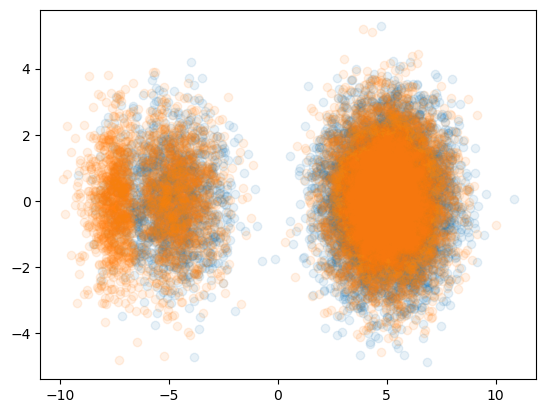

In [209]:
plt.scatter(X[:, -1, 0], X[:, -1, 1], alpha=0.1)
plt.scatter(X_train[:, -1, 0], X_train[:, -1, 1], alpha=0.1)

# plt.scatter(X_chern[:, -1, 0], X_chern[:,-1, 1], alpha=0.1)

In [225]:
from guided_models import GuidedDiffusion
guided_per = GuidedDiffusion(dist0, alpha_t, lambda x, t: np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B)), upper_bound=B, temperature=1, S=10_000)
X_per = guided_per.calc_samples()


Reverse Diffusion Progress: 100%|██████████| 19/19 [02:04<00:00,  6.57s/it]


In [226]:
B = 3
k = 2
L_r = B*k/4
from mixture_guidance import MixtureSpecificGuidance
diffusion_msg = MixtureSpecificGuidance(dist0, alpha_t, reward_func_hard, L_r = L_r, value_fn=lambda t, x: (np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B))),   S = 10_000, delta = 0.01, use_trace = False)
X_msg = diffusion_msg.calc_samples()

Mixture reverse: 100%|██████████| 19/19 [00:51<00:00,  2.73s/it]


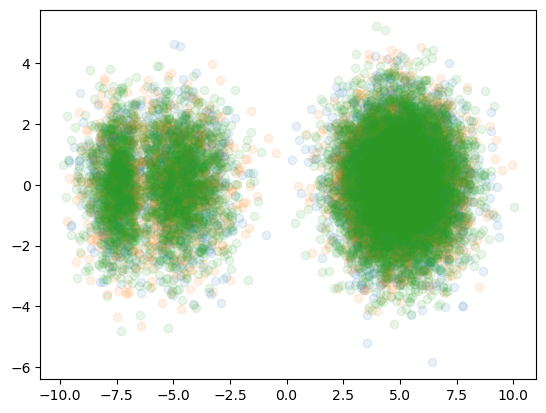

In [ ]:
plt.scatter(X_per[:, -1, 0], X_per[:, -1, 1], alpha=0.1)
plt.scatter(X_msg[:, -1, 0], X_msg[:, -1, 1], alpha=0.1)
plt.scatter(X_train[:, -1, 0], X_train[:, -1, 1], alpha=0.1)


In [217]:
X_train.shape

(10000, 20, 2)

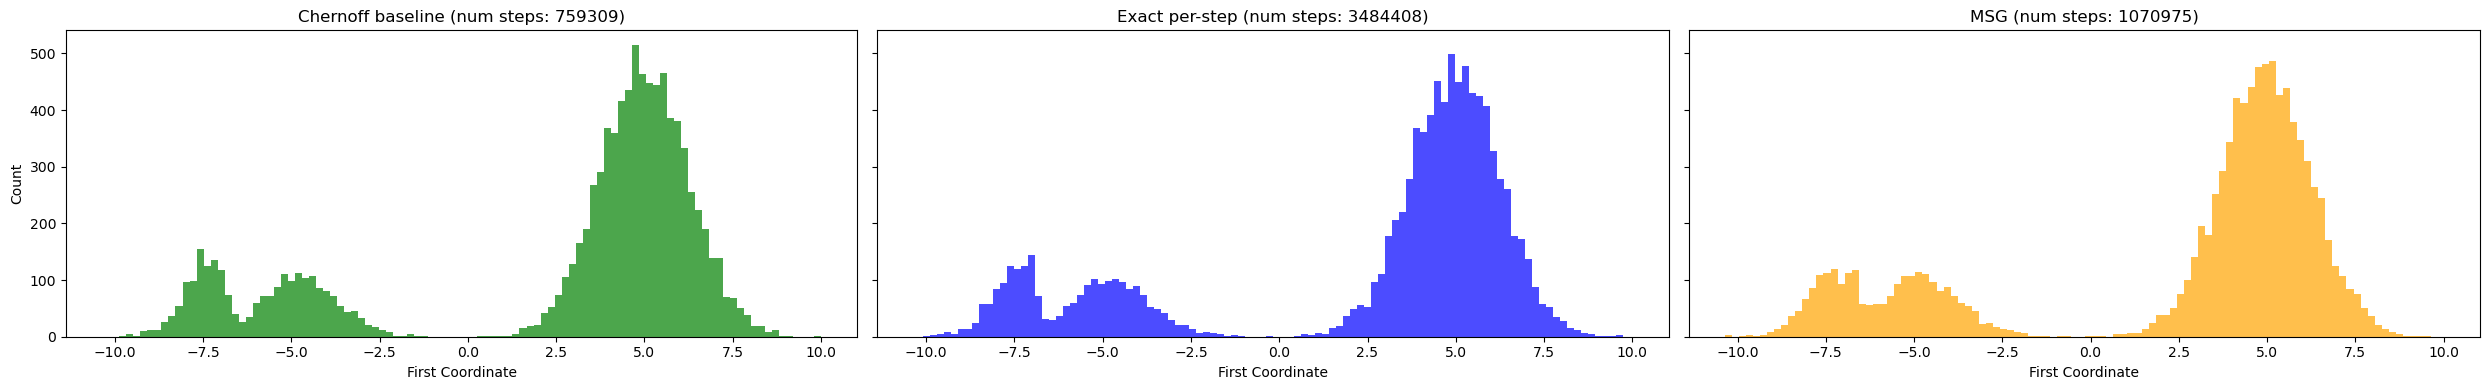

In [232]:
fig, axs = plt.subplots(1, 3, figsize=(25, 4), sharex=True, sharey=True)

axs[0].hist(X_train[:, -1, 0], bins=100, alpha=0.7, color='green')
axs[0].set_title('Chernoff baseline (num steps: {})'.format(chernoff_guided.num_steps))
axs[0].set_xlabel('First Coordinate')
axs[0].set_ylabel('Count')

axs[1].hist(X_per[:, -1, 0], bins=100, alpha=0.7, color='blue')
axs[1].set_title('Exact per-step (num steps: {})'.format(guided_per.num_steps))
axs[1].set_xlabel('First Coordinate')

axs[2].hist(X_msg[:, -1, 0], bins=100, alpha=0.7, color='orange')
axs[2].set_title('MSG (num steps: {})'.format(diffusion_msg.num_steps))
axs[2].set_xlabel('First Coordinate')


plt.tight_layout()
plt.show()

In [227]:
chernoff_guided.num_steps

759309

In [228]:
diffusion_msg.num_steps

1070975

In [229]:
guided_per.num_steps

3484408

In [230]:
chernoff_guided.num_steps/diffusion_msg.num_steps

0.7089885384812904

In [231]:
chernoff_guided.num_steps/guided_per.num_steps

0.21791621417468907

In [204]:
chernoff_guided.taus

array([-3.84734929e-01, -2.65961766e-01, -1.80751085e-01, -8.86524022e-02,
       -8.15645850e-04,  1.61344767e-01,  3.42201352e-01,  2.64597982e-01,
        6.85235679e-01,  1.38424695e+00,  1.05877554e+00,  6.85857058e-01,
        8.94437551e-01,  9.78788793e-01,  1.02378511e+00,  9.47133064e-01,
        4.27836359e-01,  7.99283862e-01,  7.75289595e-01])

In [201]:
bl = chernoff_guided.baseline

In [202]:
def visualize_baseline_2d(baseline, t_scalar, grid_size=100, value_range=(-3, 3)):
        """
        Visualizes log u_{t+1}(y_{t+1}) over a 2D grid for d=2.
        Args:
            baseline: LogUBaselineNet instance
            t_scalar: time index (int)
            grid_size: number of points per axis
            value_range: tuple (min, max) for each axis
        """
        import matplotlib.pyplot as plt

        if baseline.d != 2:
            raise ValueError("Visualization only supported for d=2.")

        x = np.linspace(value_range[0], value_range[1], grid_size)
        y = np.linspace(value_range[0], value_range[1], grid_size)
        xx, yy = np.meshgrid(x, y)
        grid = np.stack([xx.ravel(), yy.ravel()], axis=1)  # (grid_size^2, 2)

        with torch.no_grad():
            grid_tensor = torch.tensor(grid, dtype=torch.float32, device=baseline.device)
            logu = baseline(grid_tensor, t_scalar).cpu().numpy().reshape(grid_size, grid_size)

        plt.figure(figsize=(6, 5))
        plt.imshow(logu, extent=(value_range[0], value_range[1], value_range[0], value_range[1]),
                   origin='lower', aspect='auto', cmap='viridis')
        plt.colorbar(label='log u')
        plt.title(f"log u_{{t+1}}(y_{{t+1}}), t={t_scalar}")
        plt.xlabel("y1")
        plt.ylabel("y2")
        plt.show()

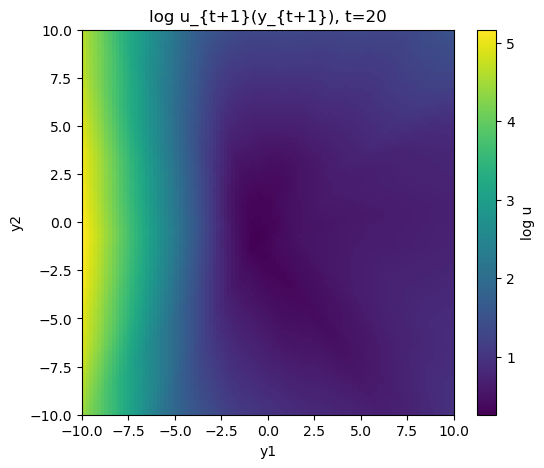

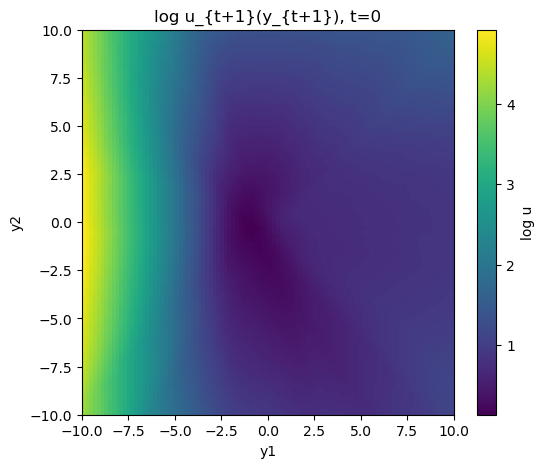

In [222]:
visualize_baseline_2d(bl, 20, grid_size=100, value_range=(-10, 10))
visualize_baseline_2d(bl, 0, grid_size=100, value_range=(-10, 10))

In [ ]:
chernoff_guided.lambdas